# Statistical Arbitrage Crypto

Some calculations to do with statistical arbitrage on binance using perpetual futures

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller
import requests
import datetime
import time
import csv
import ccxt

import seaborn as sns
import matplotlib.pyplot as plt

Fetching data for BTCUSDT...
Fetching data for ETHUSDT...
Fetching data for LINKUSDT...
Fetching data for BNBUSDT...
Fetching data for TRXUSDT...
Fetching data for DOTUSDT...
Fetching data for ADAUSDT...
Fetching data for EOSUSDT...
Fetching data for LTCUSDT...
Fetching data for BCHUSDT...
Fetching data for XRPUSDT...
Fetching data for ETCUSDT...
Fetching data for FILUSDT...
Fetching data for EGLDUSDT...
Fetching data for DOGEUSDT...
Fetching data for UNIUSDT...
Fetching data for THETAUSDT...
Fetching data for XLMUSDT...
Fetching data for SOLUSDT...
Fetching data for FTMUSDT...
Fetching data for SANDUSDT...
Fetching data for MANAUSDT...
Fetching data for AVAXUSDT...
Fetching data for GALAUSDT...
Fetching data for MATICUSDT...
Fetching data for NEARUSDT...
Fetching data for ATOMUSDT...
Fetching data for AAVEUSDT...
Fetching data for AXSUSDT...
Fetching data for ROSEUSDT...
Fetching data for XTZUSDT...
Fetching data for ICXUSDT...
Fetching data for ALGOUSDT...
Fetching data for RUNEUSDT.

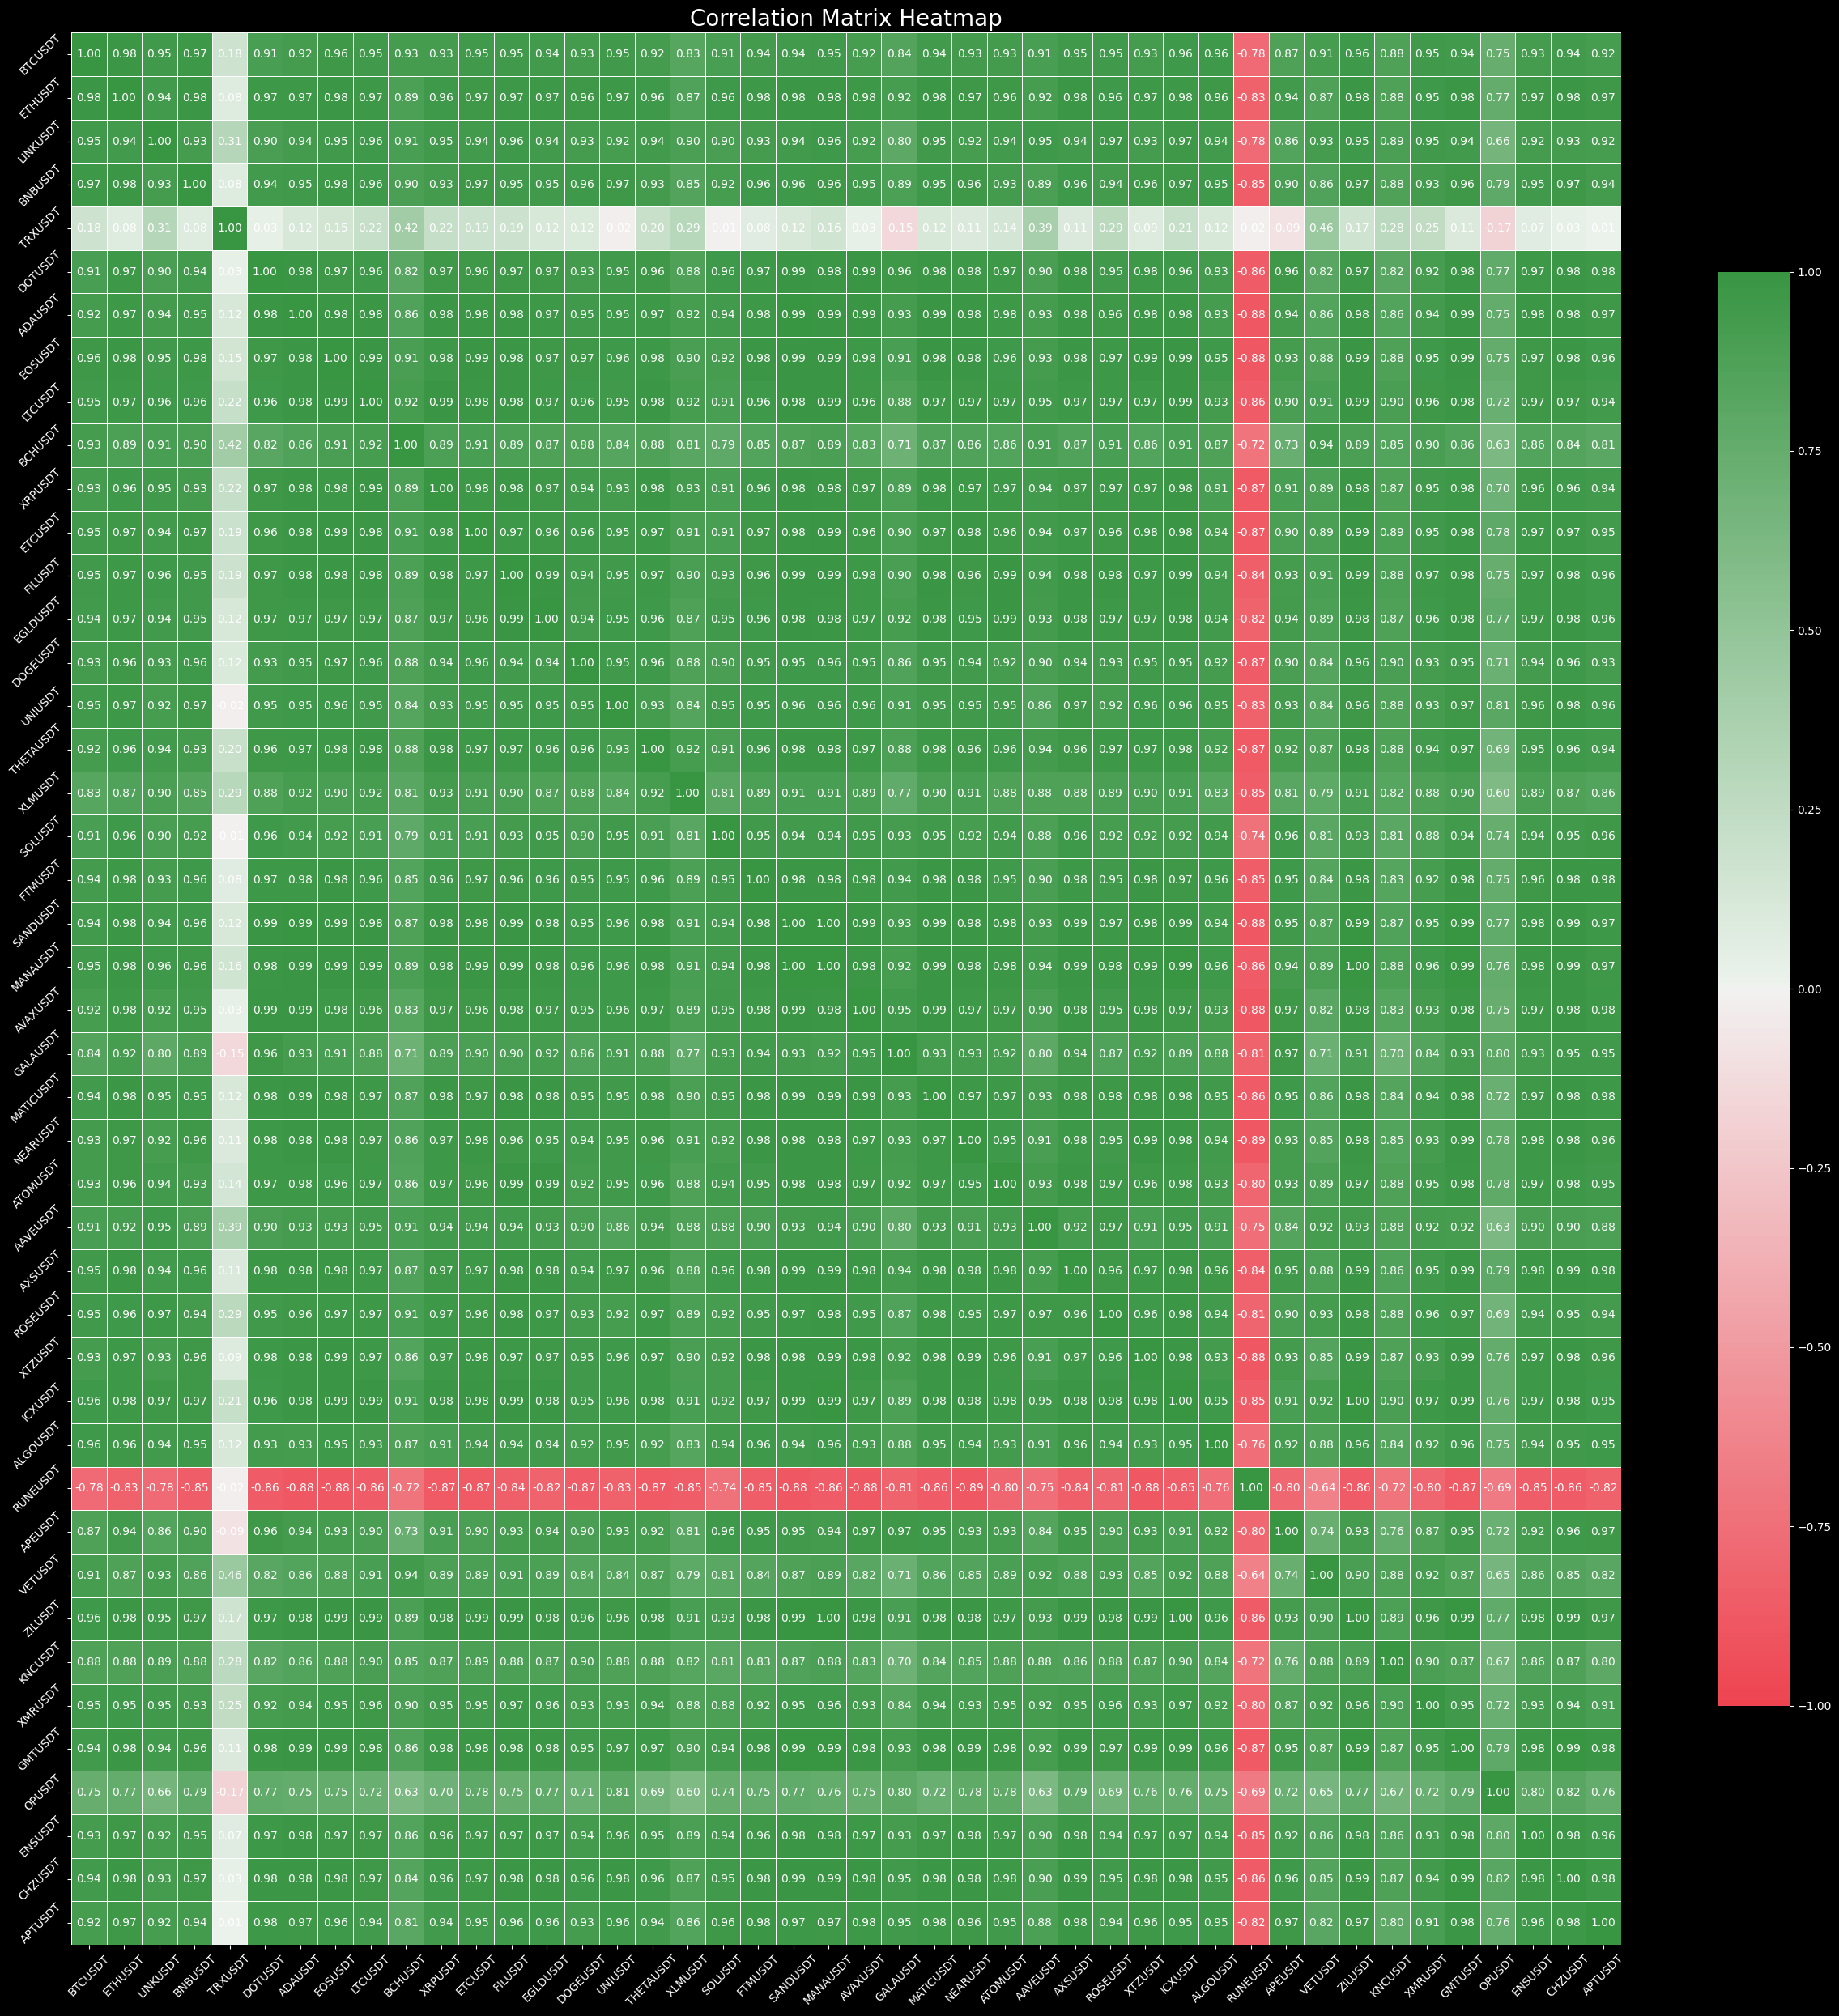

[('BTCUSDT', 'DOGEUSDT'), ('BTCUSDT', 'KNCUSDT'), ('BTCUSDT', 'XMRUSDT'), ('ETHUSDT', 'BNBUSDT'), ('ETHUSDT', 'EOSUSDT'), ('ETHUSDT', 'EGLDUSDT'), ('ETHUSDT', 'DOGEUSDT'), ('ETHUSDT', 'FTMUSDT'), ('ETHUSDT', 'MANAUSDT'), ('ETHUSDT', 'MATICUSDT'), ('ETHUSDT', 'NEARUSDT'), ('ETHUSDT', 'AXSUSDT'), ('ETHUSDT', 'ALGOUSDT'), ('ETHUSDT', 'ZILUSDT'), ('ETHUSDT', 'GMTUSDT'), ('ETHUSDT', 'CHZUSDT'), ('ETHUSDT', 'APTUSDT'), ('LINKUSDT', 'DOGEUSDT'), ('LINKUSDT', 'KNCUSDT'), ('LINKUSDT', 'XMRUSDT'), ('BNBUSDT', 'ETHUSDT'), ('BNBUSDT', 'EOSUSDT'), ('BNBUSDT', 'DOGEUSDT'), ('BNBUSDT', 'ZILUSDT'), ('DOTUSDT', 'DOGEUSDT'), ('DOTUSDT', 'FTMUSDT'), ('DOTUSDT', 'APTUSDT'), ('ADAUSDT', 'ETHUSDT'), ('ADAUSDT', 'LTCUSDT'), ('ADAUSDT', 'XRPUSDT'), ('ADAUSDT', 'DOGEUSDT'), ('ADAUSDT', 'THETAUSDT'), ('ADAUSDT', 'SANDUSDT'), ('ADAUSDT', 'MANAUSDT'), ('ADAUSDT', 'MATICUSDT'), ('ADAUSDT', 'XTZUSDT'), ('ADAUSDT', 'ZILUSDT'), ('ADAUSDT', 'GMTUSDT'), ('ADAUSDT', 'ENSUSDT'), ('ADAUSDT', 'CHZUSDT'), ('EOSUSDT', 'BNBUS

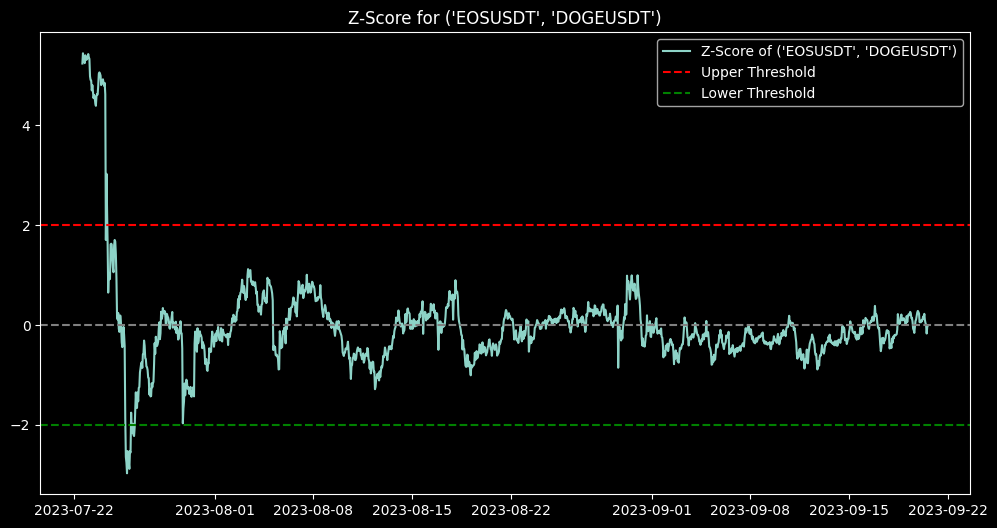

('SANDUSDT', 'DOGEUSDT') is likely mean-reverting with p-value: 0.0000


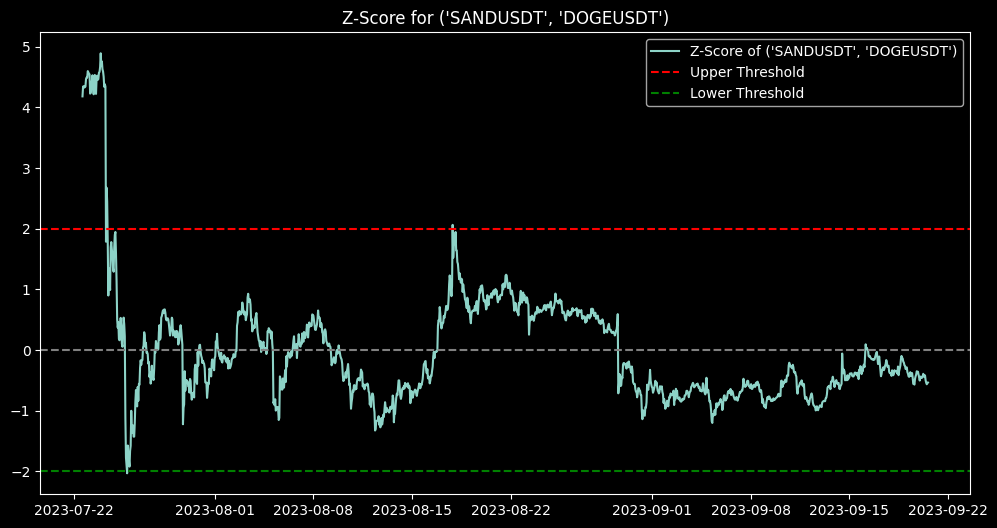

('MATICUSDT', 'DOGEUSDT') is likely mean-reverting with p-value: 0.0000


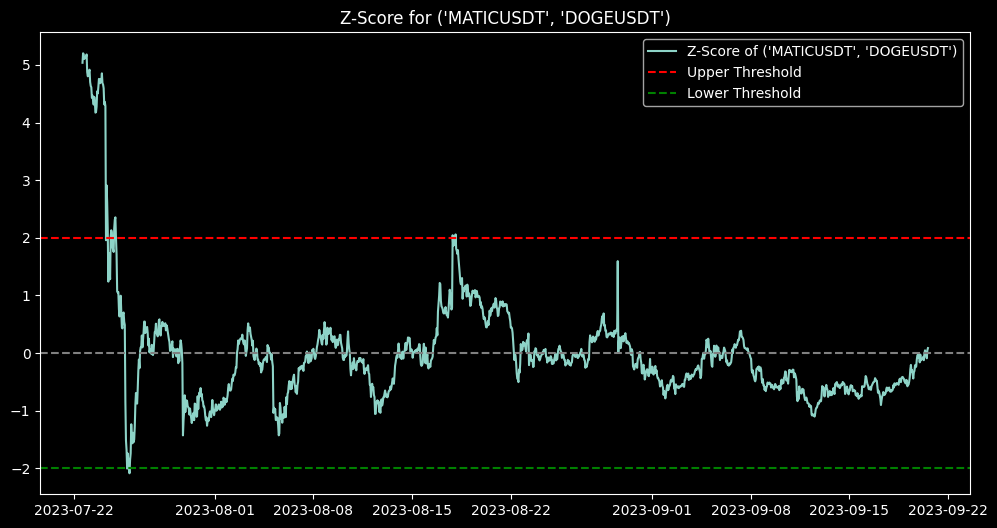

('FTMUSDT', 'DOGEUSDT') is likely mean-reverting with p-value: 0.0000


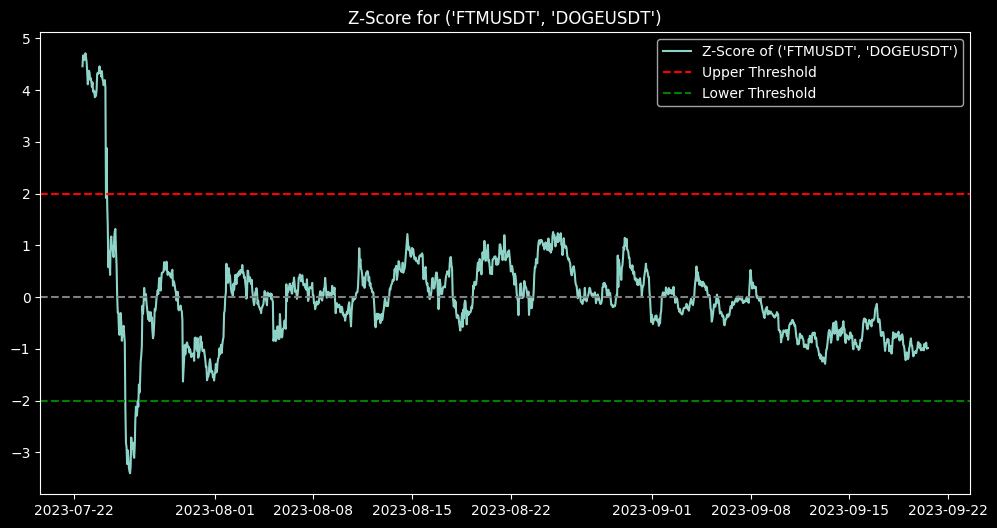

('XRPUSDT', 'THETAUSDT') is likely mean-reverting with p-value: 0.0000


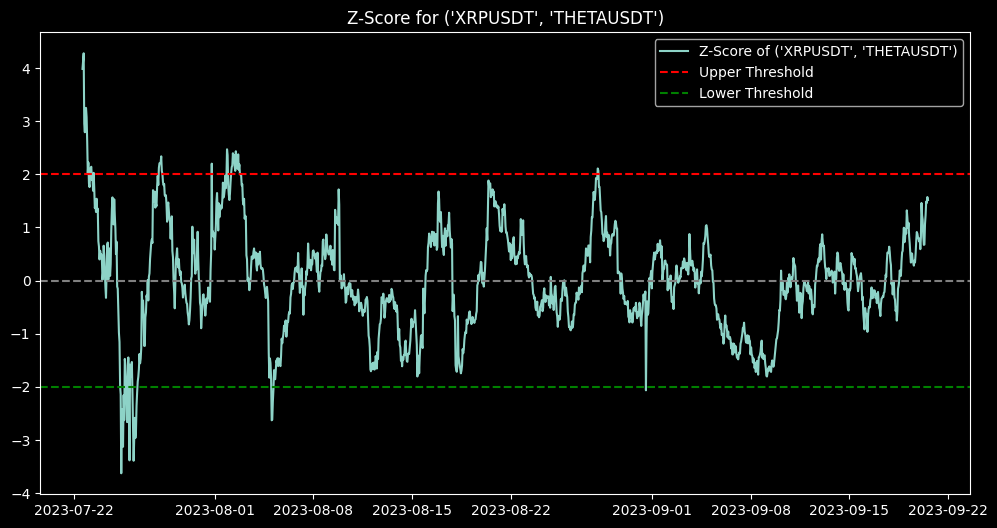

('DOGEUSDT', 'EOSUSDT') is likely mean-reverting with p-value: 0.0000


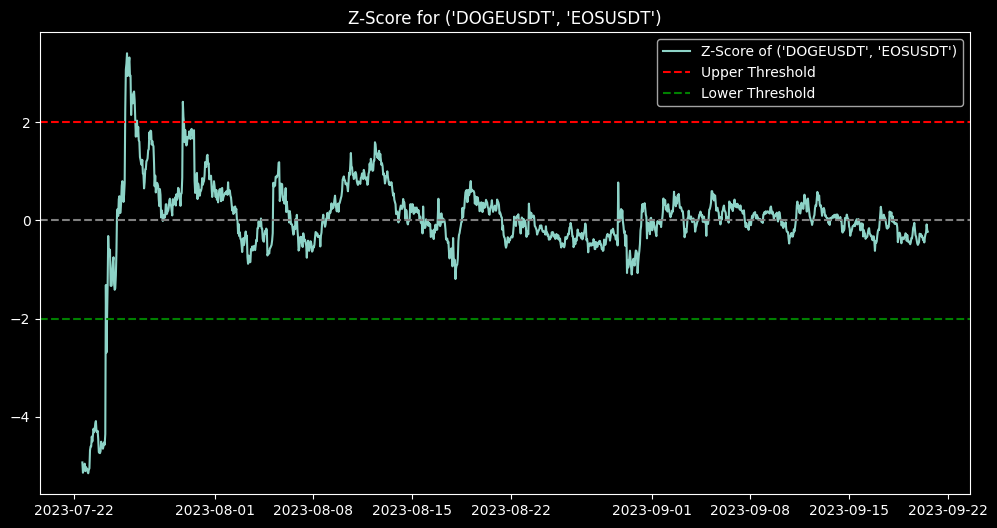

('DOGEUSDT', 'XTZUSDT') is likely mean-reverting with p-value: 0.0000


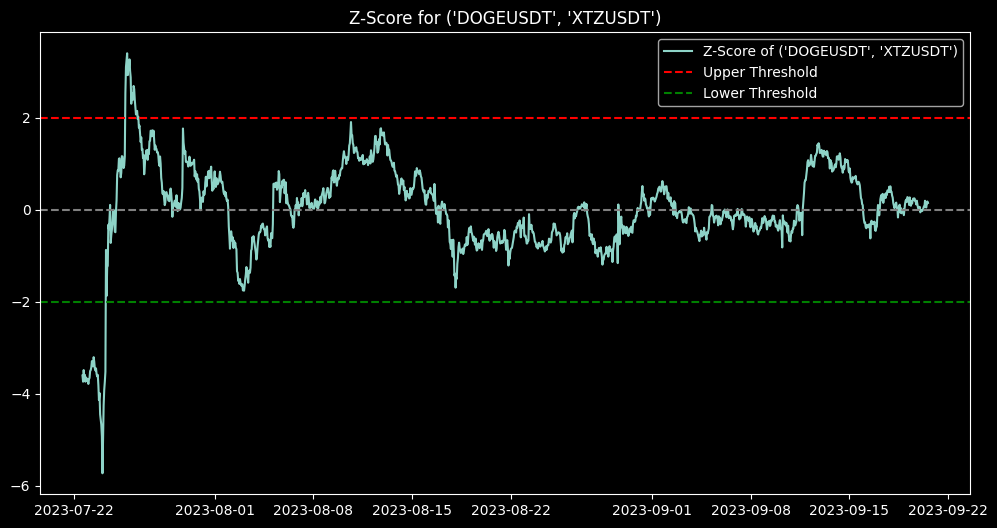

('THETAUSDT', 'XRPUSDT') is likely mean-reverting with p-value: 0.0000


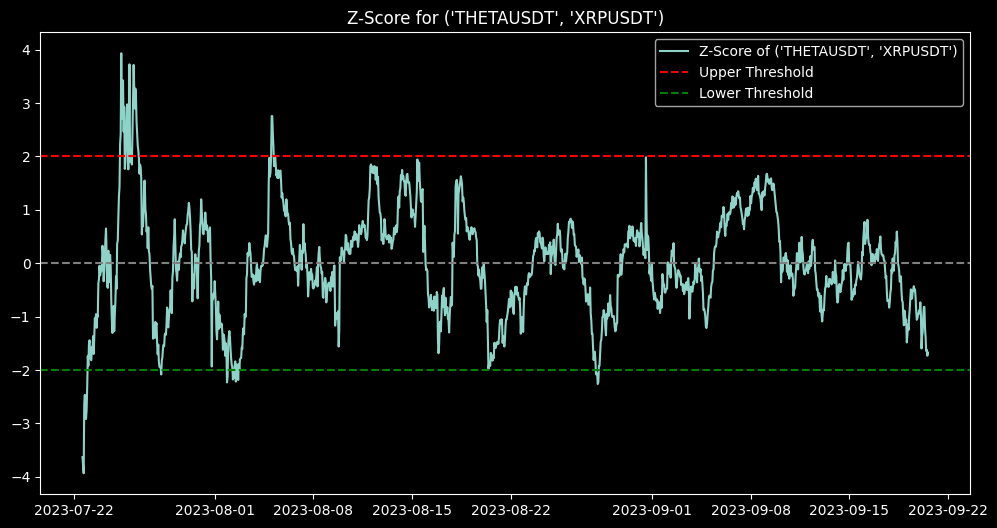

('ICXUSDT', 'DOGEUSDT') is likely mean-reverting with p-value: 0.0000


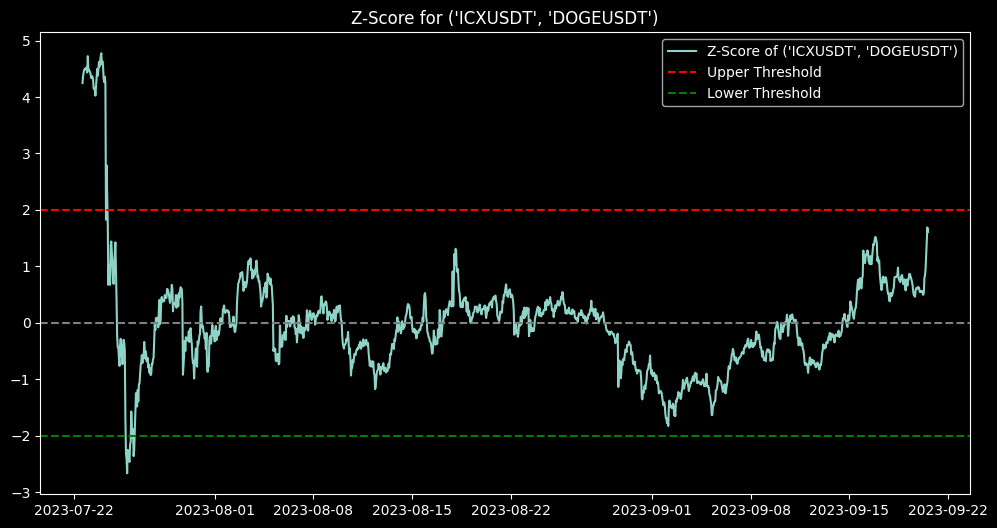

('GMTUSDT', 'DOGEUSDT') is likely mean-reverting with p-value: 0.0000


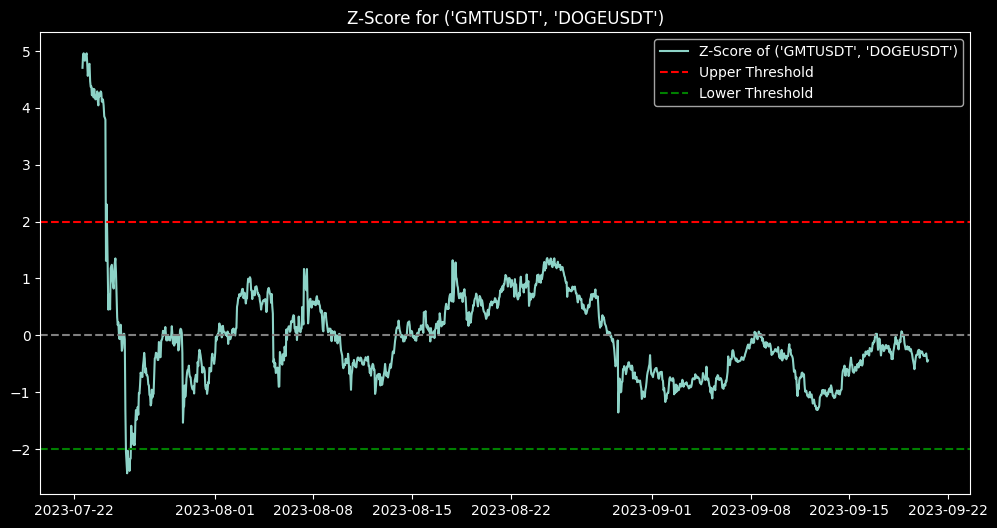

Top 10 Mean-reverting pairs: [('EOSUSDT', 'DOGEUSDT'), ('SANDUSDT', 'DOGEUSDT'), ('MATICUSDT', 'DOGEUSDT'), ('FTMUSDT', 'DOGEUSDT'), ('XRPUSDT', 'THETAUSDT'), ('DOGEUSDT', 'EOSUSDT'), ('DOGEUSDT', 'XTZUSDT'), ('THETAUSDT', 'XRPUSDT'), ('ICXUSDT', 'DOGEUSDT'), ('GMTUSDT', 'DOGEUSDT')]


In [2]:
futures_pairs =  [
    "BTCUSDT", "ETHUSDT", "LINKUSDT", "BNBUSDT", "TRXUSDT", "DOTUSDT", "ADAUSDT", "EOSUSDT", "LTCUSDT",
    "BCHUSDT", "XRPUSDT", "ETCUSDT", "FILUSDT", "EGLDUSDT", "DOGEUSDT", "UNIUSDT", "THETAUSDT", "XLMUSDT",
    "SOLUSDT", "FTMUSDT", "SANDUSDT", "MANAUSDT", "AVAXUSDT", "GALAUSDT", "MATICUSDT", "NEARUSDT",
    "ATOMUSDT", "AAVEUSDT", "AXSUSDT", "ROSEUSDT", "XTZUSDT", "ICXUSDT", "ALGOUSDT", "RUNEUSDT",
    "APEUSDT", "VETUSDT", "ZILUSDT", "KNCUSDT", "XMRUSDT", "GMTUSDT", "OPUSDT", "ENSUSDT", "CHZUSDT", "APTUSDT"
]

def fetch_historical_data(pair, since, timeframe="1h"):
    binance = ccxt.binance({'rateLimit': 1200})
    all_candles = []
    limit = 1000  
    while since < binance.milliseconds():
        candles = binance.fetch_ohlcv(pair, timeframe, since, limit)
        if len(candles) == 0:
            break
        since = candles[-1][0] + 1
        all_candles += candles
        time.sleep(binance.rateLimit / 1000)  

    df = pd.DataFrame(all_candles, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    df.set_index('timestamp', inplace=True)
    return df

def visualize_heatmap(correlation_matrix):

    plt.style.use("dark_background")

    # Creating a custom colormap: Green for positive, Red for negative correlation
    custom_cmap = sns.diverging_palette(10, 130, s=80, l=55, as_cmap=True)  # Using green-red palette

    plt.figure(figsize=(25, 25))  # Increased size

    sns.heatmap(correlation_matrix, annot=True, cmap=custom_cmap, 
                center=0, vmin=-1, vmax=1, fmt=".2f", 
                linewidths=.5, cbar_kws={"shrink": 0.75},
                annot_kws={"size": 10, "color": "white"})  # Setting the font color to white for visibility on dark background

    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.title("Correlation Matrix Heatmap", fontsize=20)  # Increased font size for the title
    plt.tight_layout()
    plt.show() 

# Initialization
binance = ccxt.binance()
two_months_ms = 2 * 30 * 24 * 60 * 60 * 1000
since = binance.milliseconds() - two_months_ms

dataframes = {}
high_correlation_pairs = []
suitable_pairs = []
spreads = {}

for pair in futures_pairs:
    print(f"Fetching data for {pair}...")
    df_close = fetch_historical_data(pair, since)["close"]
    dataframes[pair] = df_close

# Check for cointegration and compute hedge ratios and spreads
for pair in dataframes:
    for comp_pair in dataframes:
        if pair != comp_pair:
            Y = dataframes[pair]
            X = dataframes[comp_pair]
            
            # Ensure the data is aligned
            Y, X = Y.align(X, join='inner')

            # Check correlation
            correlation = Y.corr(X)
            if correlation > 0.75:
                high_correlation_pairs.append((pair, comp_pair, correlation))
                
                _, pvalue, _ = coint(Y, X)
                if pvalue < 0.05:
                    suitable_pairs.append((pair, comp_pair))
                    
                    # Calculate hedge ratio
                    X_const = sm.add_constant(X)
                    model = sm.OLS(Y, X_const).fit()
                    hedge_ratio = model.params[1]
                    
                    # Calculate spread using hedge ratio
                    spread = Y - hedge_ratio * X
                    spreads[(pair, comp_pair)] = spread

# Visualize heatmap only once
combined_df = pd.concat(dataframes, axis=1)
correlation_matrix = combined_df.corr()
visualize_heatmap(correlation_matrix)

print(suitable_pairs)

# Check for mean reversion in spreads
mean_reverting_pairs = []
adf_pvalues = {}  # To store the p-values for each pair

for pair, spread in spreads.items():
    z = (spread - spread.mean()) / spread.std()
    result = adfuller(z)
    adf_statistic = result[0]
    p_value = result[1]
    
    if p_value < 0.05:
        adf_pvalues[pair] = p_value

# Sort pairs by p-value and take the top 10
sorted_pairs = sorted(adf_pvalues.items(), key=lambda x: x[1])[:10]

for pair, p_value in sorted_pairs:
    print(f"{pair} is likely mean-reverting with p-value: {p_value:.4f}")
    mean_reverting_pairs.append(pair)
    
    # Optional: Plotting the z-score for the mean-reverting pair
    z = (spreads[pair] - spreads[pair].mean()) / spreads[pair].std()
    plt.figure(figsize=(12, 6))
    plt.plot(z, label=f'Z-Score of {pair}')
    plt.axhline(0, color='gray', linestyle='--')
    plt.axhline(2.0, color='red', linestyle='--', label='Upper Threshold')
    plt.axhline(-2.0, color='green', linestyle='--', label='Lower Threshold')
    plt.legend()
    plt.title(f'Z-Score for {pair}')
    plt.show()

print("Top 10 Mean-reverting pairs:", mean_reverting_pairs)

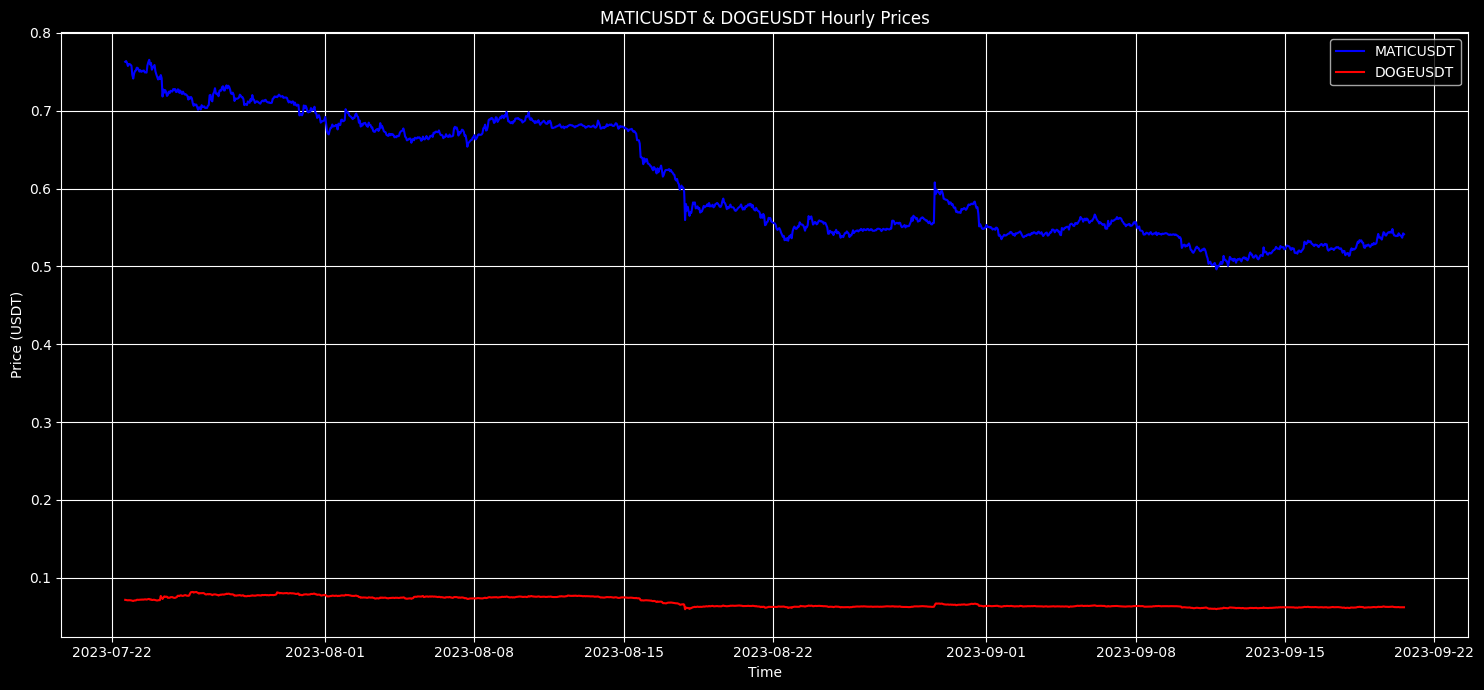

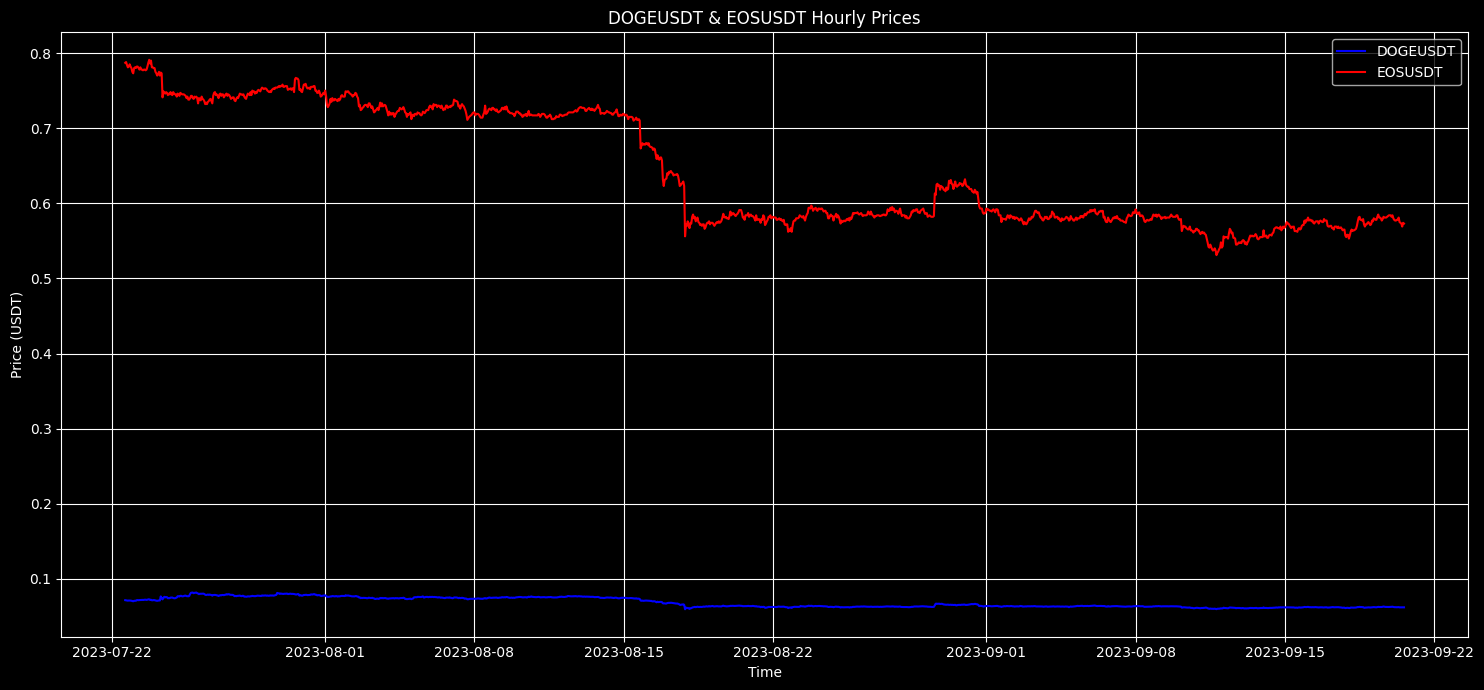

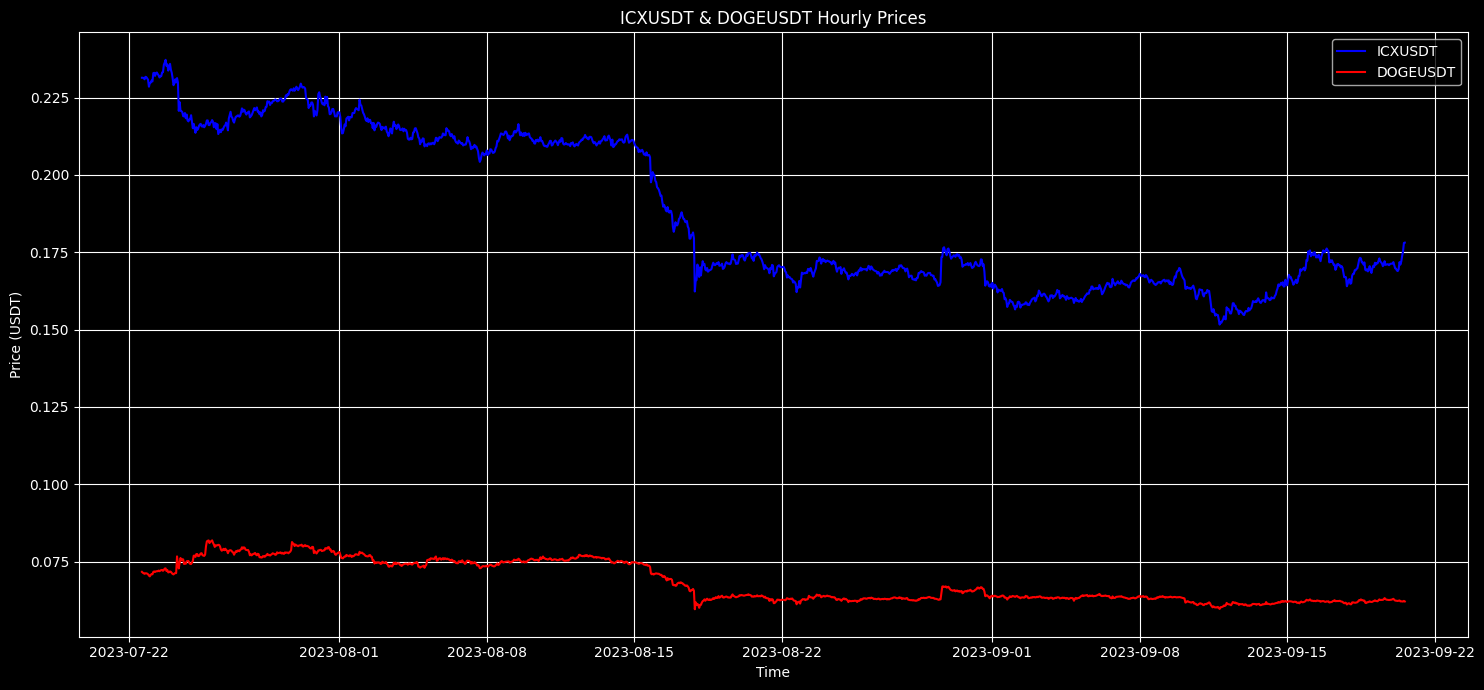

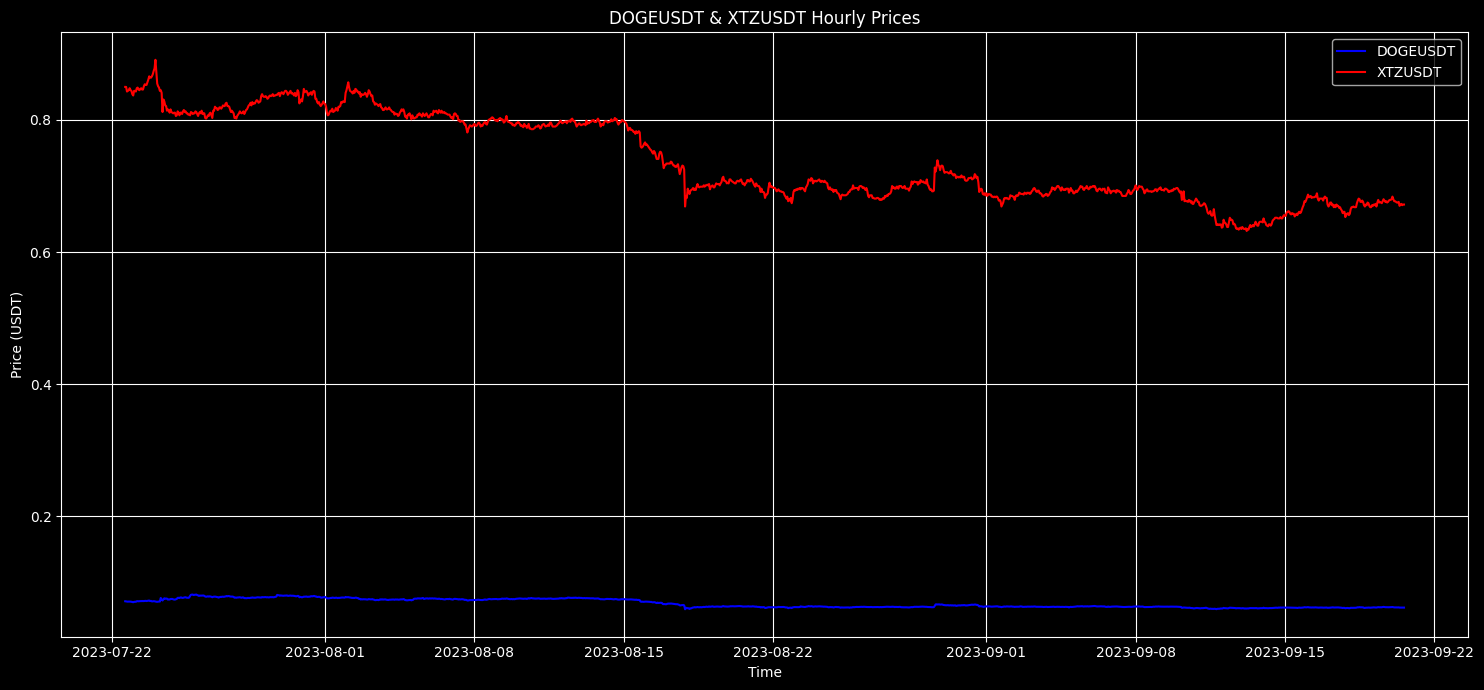

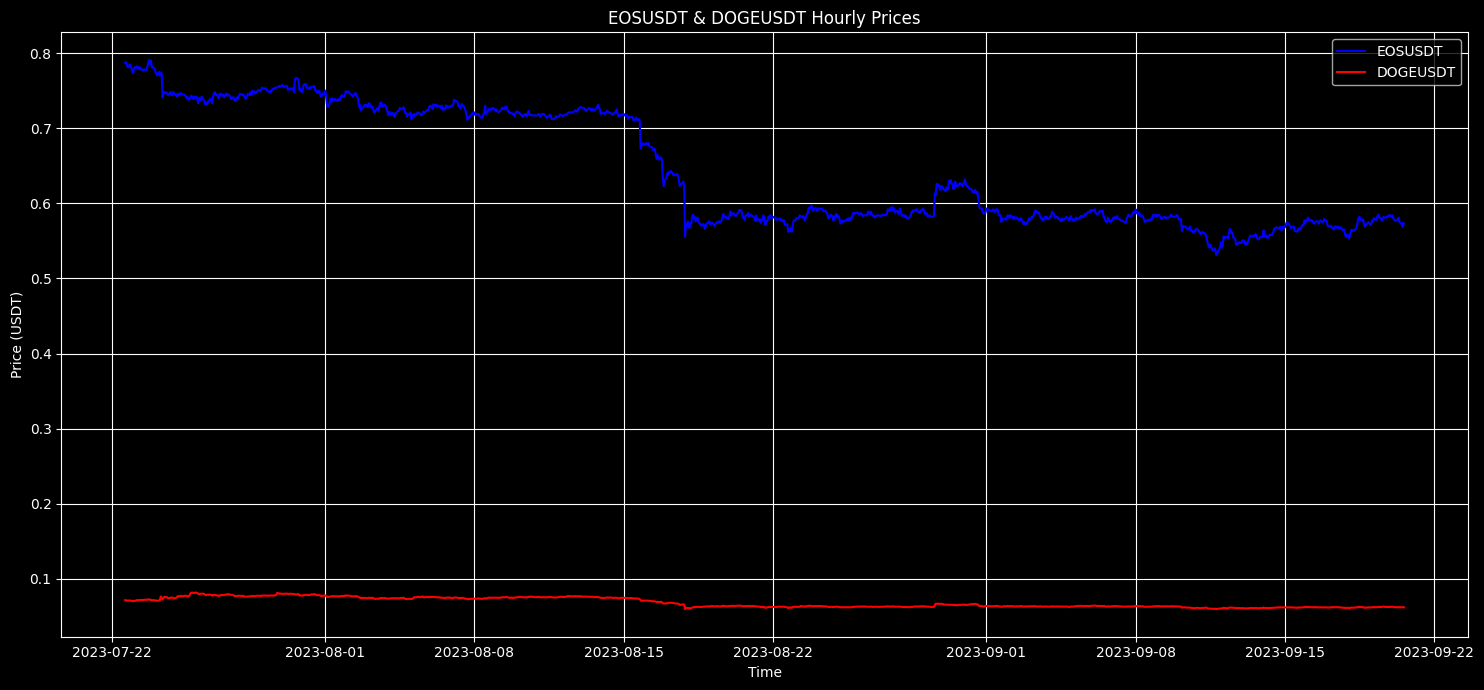

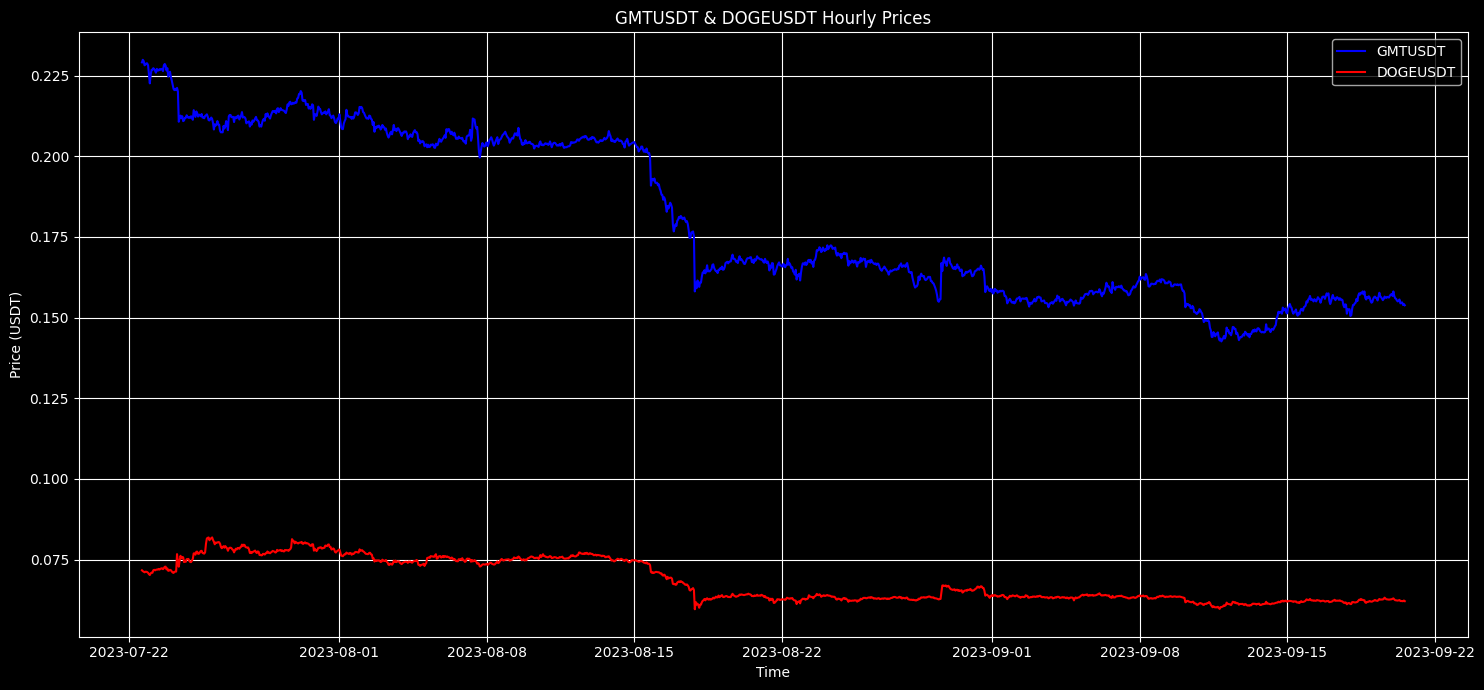

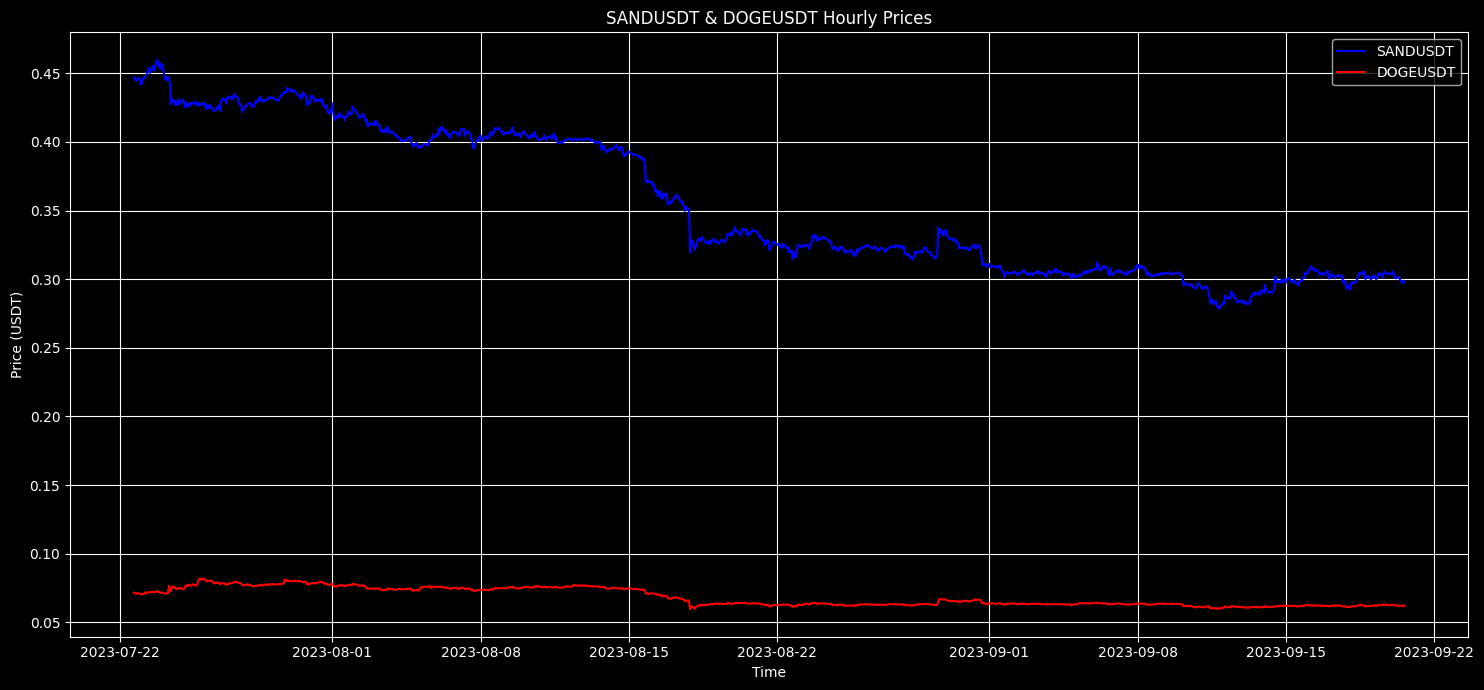

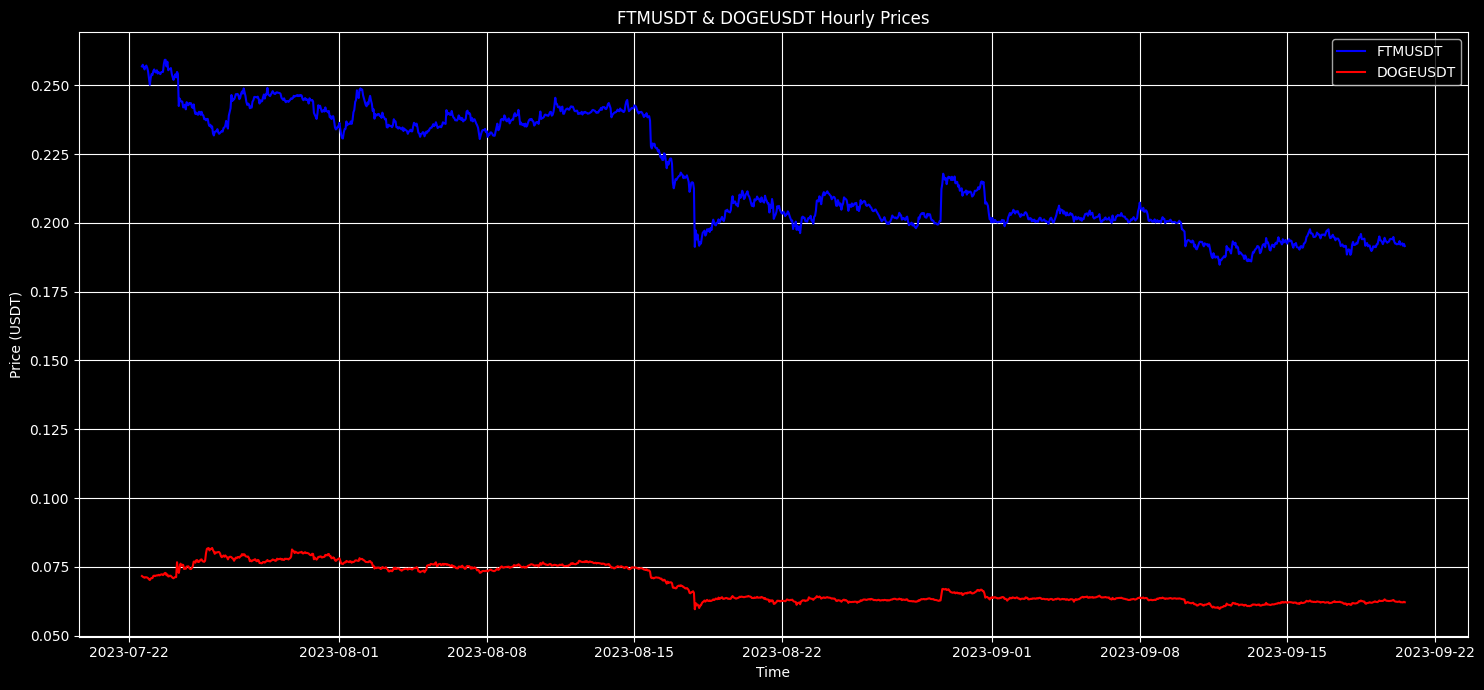

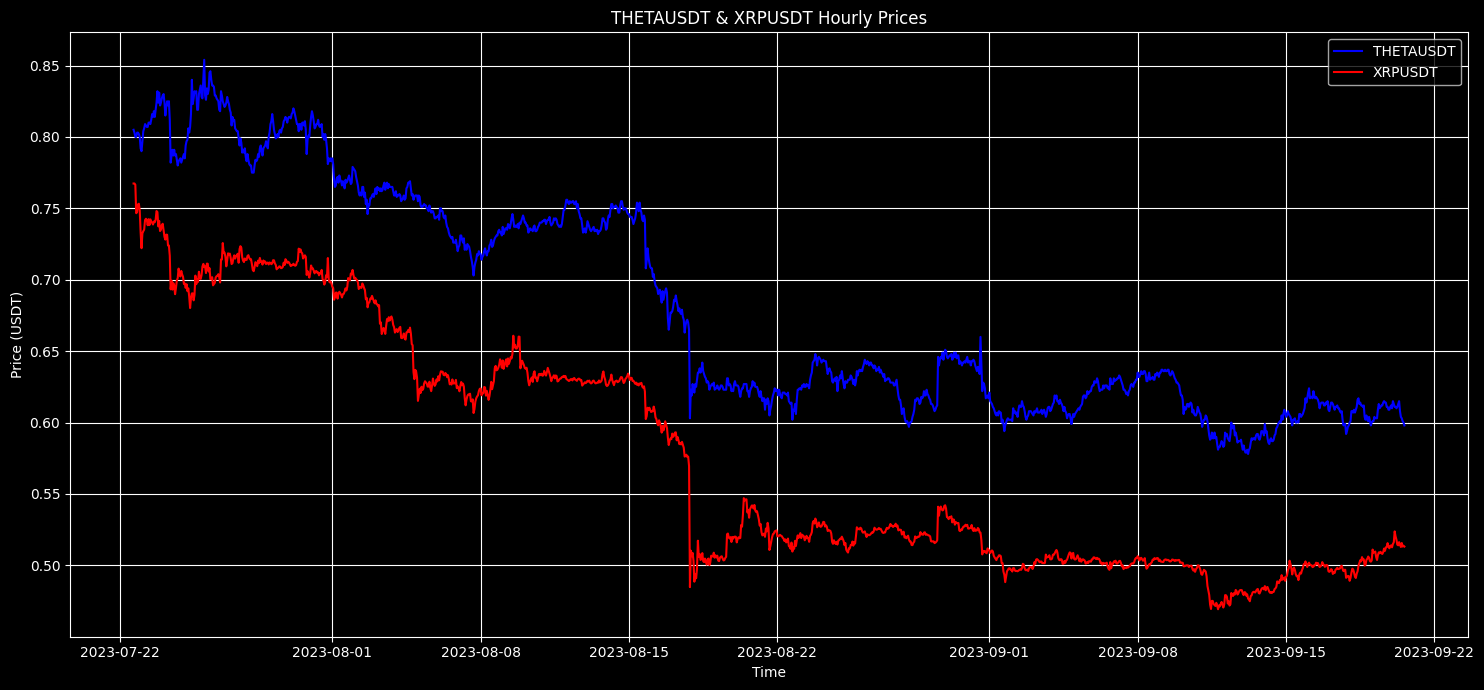

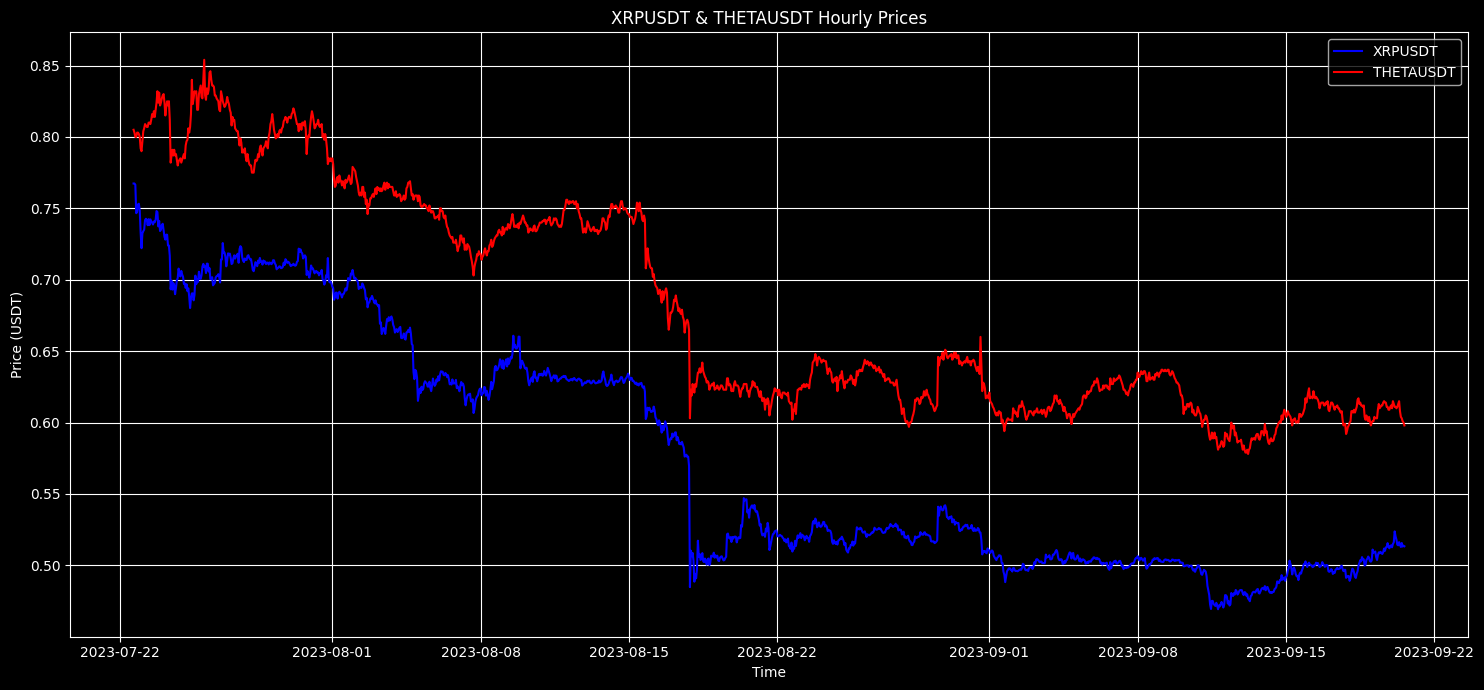

In [3]:

unique_pairs_to_plot = list(set(mean_reverting_pairs))

# Initialization
binance = ccxt.binance()
two_months_ms = 2 * 30 * 24 * 60 * 60 * 1000
since = binance.milliseconds() - two_months_ms

for pair_a, pair_b in unique_pairs_to_plot:
    # Fetch data for both pairs
    df_a = fetch_historical_data(pair_a, since)
    df_b = fetch_historical_data(pair_b, since)
    
    # Plotting
    plt.figure(figsize=(15, 7))
    plt.plot(df_a.index, df_a['close'], label=pair_a, color='blue')
    plt.plot(df_b.index, df_b['close'], label=pair_b, color='red')
    
    # Adding some visual configurations
    plt.title(f"{pair_a} & {pair_b} Hourly Prices")
    plt.xlabel('Time')
    plt.ylabel('Price (USDT)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()